# Analysis - Agewise Comparisons
Notebook for testing and analysis of single cell human, mouse and opossum data from Herring and Sepp papers. Primary methods will be differential gene expression analysis (using [DeSeq2](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html)) and GO term analysis (using [g:Profiler](https://biit.cs.ut.ee/gprofiler/gost) via the scanpy wrapper). Note that DeSeq2 is an R package, so we will need to use the [rpy2](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html) package to use R magic and interface with R. [anndata2ri](https://github.com/theislab/anndata2ri) allows the conversion of anndata objects into SingleCellExperiment objects for use in R. Aim is to determine a robust approach that can be applied to all datasets.

In [1]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import qc_metrics as qc
import anndata2ri
import rpy2
import os
import seaborn as sns
import statistics as stats
import math

anndata2ri.activate()

%load_ext rpy2.ipython

/tmp/ipykernel_3764200/1569607228.py:13: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [2]:
herring = ad.read_h5ad('/group/ll005/cmcphan/herring_data/Processed_data_RNA-all_full-counts-and-downsampled-CPM.h5ad')
sepp_human = ad.read_h5ad('/group/ll005/cmcphan/sepp_data/sepp_human_normal_reduced.h5ad')
sepp_mouse = ad.read_h5ad('/group/ll005/cmcphan/sepp_data/sepp_mouse_normal_reduced.h5ad')
sepp_opossum = ad.read_h5ad('/group/ll005/cmcphan/sepp_data/sepp_opossum_normal_reduced.h5ad')

In [5]:
for d in [herring, sepp_human, sepp_mouse, sepp_opossum]:
    print(d.shape)

(154748, 26747)
(144347, 27260)
(60028, 20424)
(88433, 28773)


### Human
Start by looking at changes between adjacent time periods in each human dataset. To begin, we need to decide what the design formula should look like for each dataset, based on the available metadata. Try using a maximal formula which includes as many potentially relevant factors as possible and then trim down based on dispersions for each factor, deciding whether or not they contribute an appreciable amount of extra information.

In [3]:
# List of available metadata that we might want to control for
herring.obs.columns

Index(['batch', 'RL#', 'age', 'chem', 'concat_id', 'numerical_age', 'stage_id',
       'Sex', 'Race', 'PMI', 'Brain Regions*', 'Cause of Death', 'ICD-10 Code',
       'ICD-10 category', 'Oxygen/No Oxygen', 'Date-of-Collection',
       'Collection_year', 'Library Prep Date', 'Library Prep Lot',
       'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
       'log1p_total_counts', 'doublet_score', 'log10_gene_counts',
       'log10_UMI_counts', 'percent_mito', 'percent_ribo', 'n_counts',
       'leiden', 'mat/dev', 'cell_type', 'major_clust', 'sub_clust',
       'combined-leiden', 'Astro_GFAP_dev-traj', 'Astro_SLC1A2_dev-traj',
       'L2_CUX2_LAMP5_dev-traj', 'L3_CUX2_PRSS12_dev-traj',
       'L4_RORB_LRRK1_dev-traj', 'L4_RORB_MET_dev-traj',
       'L4_RORB_MME_dev-traj', 'L5-6_THEMIS_CNR1_dev-traj',
       'L5-6_THEMIS_NTNG2_dev-traj', 'L5-6_TLE4_HTR2C_dev-traj',
       'L5-6_TLE4_SCUBE1_dev-traj', 'L5-6_TLE4_SORCS1_dev-traj',
       'Micro_dev-traj', 'OPC_dev-traj', 'OPC_

Expected confounding factors are sex, chemistry, possibly race, library prep lot, possibly PMI, with the main factor we're interested in being age.\
Possible starting formula '~ age + Sex * chem * Race'

Since these tools are for bulk data, we will pseudobulk in various ways to match this. First, we want to see how adjacent time periods compare, so we will combine batches with the same sample age.

In [4]:
herring_age_bulk = sc.get.aggregate(herring, by='age', func='sum')
herring_age_bulk.X = herring_age_bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
herring_age_bulk

AnnData object with n_obs × n_vars = 24 × 26747
    obs: 'age'
    var: 'gene_ids', 'feature_types', 'non-unique_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'sum'

This produces 24 groups. Aggregating based on age, sex, chemistry and race gives 26 groups.

In [5]:
herring_age_bulk = sc.get.aggregate(herring, by=['age', 'Sex', 'chem', 'Race'], func='sum')
herring_age_bulk.X = herring_age_bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
herring_age_bulk

AnnData object with n_obs × n_vars = 26 × 26747
    obs: 'age', 'Sex', 'chem', 'Race'
    var: 'gene_ids', 'feature_types', 'non-unique_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'sum'

This is nowhere close to a full rank matrix, and therefore these cannot be directly modelled using the LRT to check for effects due to confounding factors:

In [3]:
%%R 
library(DESeq2)
library(sva)
library(pheatmap)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Attaching package: ‘S4Vectors’

The following object is masked from ‘package:utils’:

    findMatches

The following objects are masked from ‘package:base’:

    expand.grid, I, unname

Loading required package: IRanges
Loading required package: GenomicRanges
Loading required package: GenomeInfoDb
Loading require

#### Testing

In [7]:
%%R -i herring_age_bulk
herring_age_bulk

class: SingleCellExperiment 
dim: 26747 26 
metadata(0):
assays(2): X sum
rownames(26747): RP11-34P13.7 AL627309.1 ... AC145205.1 CU459201.1
rowData names(15): gene_ids feature_types ... dispersions
  dispersions_norm
colnames(26): 2d_F_v3_White 2yr_M_v2_White ... ga24_M_v3_AA
  ga34_F_v3_White
colData names(4): age Sex chem Race
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [8]:
%%R
dds = DESeqDataSet(herring_age_bulk, design = ~ age + Sex + chem + Race)

renaming the first element in assays to 'counts'
converting counts to integer mode
Error in checkFullRank(modelMatrix) : 
  the model matrix is not full rank, so the model cannot be fit as specified.
  One or more variables or interaction terms in the design formula are linear
  combinations of the others and must be removed.

  Please read the vignette section 'Model matrix not full rank':

  vignette('DESeq2')


RInterpreterError: Failed to parse and evaluate line 'dds = DESeqDataSet(herring_age_bulk, design = ~ age + Sex + chem + Race)\n'.
R error message: "Error in checkFullRank(modelMatrix) : \n  the model matrix is not full rank, so the model cannot be fit as specified.\n  One or more variables or interaction terms in the design formula are linear\n  combinations of the others and must be removed.\n\n  Please read the vignette section 'Model matrix not full rank':\n\n  vignette('DESeq2')"
R stdout:
renaming the first element in assays to 'counts'
converting counts to integer mode
Error in checkFullRank(modelMatrix) : 
  the model matrix is not full rank, so the model cannot be fit as specified.
  One or more variables or interaction terms in the design formula are linear
  combinations of the others and must be removed.

  Please read the vignette section 'Model matrix not full rank':

  vignette('DESeq2')

Similarly, trying to create surrogate variables using SVA fails because using just our condition (age) leaves us with almost perfect collinearity between our samples and ages (i.e. the 'system is computationally singular'), since most ages only have a single sample: 

In [9]:
%%R
svaFull = model.matrix(~ age, colData(herring_age_bulk))
svaNull = model.matrix(~ 1, colData(herring_age_bulk))
svaseq = svaseq(assays(herring_age_bulk)$X, svaFull, svaNull, n.sv=3)

Number of significant surrogate variables is:  3 
Iteration (out of 5 ):Error in solve.default(t(mod) %*% mod) : 
  system is computationally singular: reciprocal condition number = 7.4443e-19


RInterpreterError: Failed to parse and evaluate line 'svaFull = model.matrix(~ age, colData(herring_age_bulk))\nsvaNull = model.matrix(~ 1, colData(herring_age_bulk))\nsvaseq = svaseq(assays(herring_age_bulk)$X, svaFull, svaNull, n.sv=3)\n'.
R error message: 'Error in solve.default(t(mod) %*% mod) : \n  system is computationally singular: reciprocal condition number = 7.4443e-19'

In [10]:
sc.pp.combat(herring, key='batch', covariates=['Sex', 'chem', 'Race'])

LinAlgError: Singular matrix

Similarly, the ComBat method also fails because of a singular matrix. This leaves us with very limited options to statistically control for our possible confounding variables, and we are forced to assume that they have no significant effect. We will try to limit any possible effect by using only the most highly variable genes and may choose to restrict our choices further using a stricter p-value cutoff.

#### Herring Analysis

In [4]:
# Grab only our highly variable genes as input
herring_highly_variable = herring[:,herring.var['highly_variable']==True]
bulk = sc.get.aggregate(herring_highly_variable, by=['age', 'major_clust', 'Sex', 'chem', 'Race', 'Library Prep Lot', 'PMI'], func='sum')
bulk = bulk[bulk.obs['major_clust']!='Poor-Quality'].copy() # Exclude poor quality cells
# Pseudobulk based on cell type and available cofactors for each age group
bulk.X = bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
# Convert non-string metadata to strings for import into R
for col in bulk.obs:
    if type(bulk.obs[col].values[0]) != str:
        bulk.obs[col] = [str(x) for x in bulk.obs[col]]
bulk

AnnData object with n_obs × n_vars = 373 × 4999
    obs: 'age', 'major_clust'
    var: 'gene_ids', 'feature_types', 'non-unique_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'sum'

Possible that only using the highly variable genes is flattening the DEG curve somewhat by making ages more similar to one another, since we're looking at a restricted pool of genes. Try using all genes as well and see if it makes much difference.

In [6]:
# Grab all genes as input
bulk = sc.get.aggregate(herring, by=['age', 'major_clust', 'Sex', 'chem', 'Race', 'Library Prep Lot', 'PMI'], func='sum')
bulk = bulk[bulk.obs['major_clust']!='Poor-Quality'].copy() # Exclude poor quality cells
# Pseudobulk based on cell type and available cofactors for each age group
bulk.X = bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
# Convert non-string metadata to strings for import into R
for col in bulk.obs:
    if type(bulk.obs[col].values[0]) != str:
        bulk.obs[col] = [str(x) for x in bulk.obs[col]]
bulk

AnnData object with n_obs × n_vars = 415 × 26747
    obs: 'age', 'major_clust', 'Sex', 'chem', 'Race', 'Library Prep Lot', 'PMI'
    var: 'gene_ids', 'feature_types', 'non-unique_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'sum'

In [5]:
# Get order of age labels
age_order = herring_highly_variable.obs[['age', 'numerical_age']].sort_values(by='numerical_age').drop_duplicates().values
age_order

array([['ga22', -0.3452054794520548],
       ['ga24', -0.30684931506849317],
       ['ga34', -0.11506849315068493],
       ['2d', 0.005479452054794521],
       ['34d', 0.09315068493150686],
       ['86d', 0.2356164383561644],
       ['118d', 0.3232876712328767],
       ['179d', 0.4904109589041096],
       ['301d', 0.8246575342465754],
       ['422d', 1.1561643835616437],
       ['627d', 1.7178082191780821],
       ['2yr', 2.0],
       ['3yr', 3.0],
       ['4yr', 4.0],
       ['6yr', 6.0],
       ['8yr', 8.0],
       ['10yr', 10.0],
       ['12yr', 12.0],
       ['14yr', 14.0],
       ['16yr', 16.0],
       ['17yr', 17.0],
       ['20yr', 20.0],
       ['25yr', 25.0],
       ['40yr', 40.0]], dtype=object)

In [6]:
# Dictionary version for easily grabbing numerical age
age_order_dict = {}
for age, numerical_age in age_order:
    age_order_dict[age] = numerical_age
age_order_dict

{'ga22': -0.3452054794520548,
 'ga24': -0.30684931506849317,
 'ga34': -0.11506849315068493,
 '2d': 0.005479452054794521,
 '34d': 0.09315068493150686,
 '86d': 0.2356164383561644,
 '118d': 0.3232876712328767,
 '179d': 0.4904109589041096,
 '301d': 0.8246575342465754,
 '422d': 1.1561643835616437,
 '627d': 1.7178082191780821,
 '2yr': 2.0,
 '3yr': 3.0,
 '4yr': 4.0,
 '6yr': 6.0,
 '8yr': 8.0,
 '10yr': 10.0,
 '12yr': 12.0,
 '14yr': 14.0,
 '16yr': 16.0,
 '17yr': 17.0,
 '20yr': 20.0,
 '25yr': 25.0,
 '40yr': 40.0}

In [7]:
%%R -i bulk
bulk

class: SingleCellExperiment 
dim: 4999 373 
metadata(0):
assays(2): X sum
rownames(4999): RP5-857K21.4 SAMD11 ... S100B AL354822.1
rowData names(15): gene_ids feature_types ... dispersions
  dispersions_norm
colnames(373): 2d_L2-3_CUX2 2d_L4_RORB ... ga34_Micro ga34_Vas
colData names(2): age major_clust
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


### Adjacent ages

In [165]:
# cofactors = [x for x in rpy2.robjects.r['bulk'].obs][2:] # Get (possibly transformed) column names for cofactors
# design_formulae = {}

# Build design formula - add cofactors sequentially to base by first checking if the factors are identical in each group
    # if not, add it to the formula. This is necessary to avoid DESeq2 throwing an error when trying to build a matrix
    # based on a design with identical factors. NOTE: This will only work if the factor is full rank, just checking for this is not sufficient
#    print('Building design matrix:')
#    rpy2.robjects.r("design = '~age+major_clust'")
#    for factor in cofactors:
#        rpy2.robjects.r(str("if(unique(colData(bulk[,bulk$age=='{prev_age}'])${factor}) != \
#        unique(colData(bulk[,bulk$age=='{cur_age}'])${factor}))".format(prev_age=prev_age, cur_age=cur_age, factor=factor)+
#        "{ design = paste(design, '+', '"+factor+"', sep='') }"))
#    design = rpy2.robjects.r['design']
#    print('Design matrix = '+design)
#    design_formulae[str(cur_age+'/'+prev_age)] = design

See note in the above - the results generated below cannot have cofactors controlled for as they need to be full rank

In [10]:
l = len(herring.obs['age'].drop_duplicates().values)
path = '/group/ll005/cmcphan/notebooks/analysis/results/herring/poor_quality_excl/all_genes/' # Filepath for results directory
for i in range(1, l):
    cur_age = age_order[i][0]
    prev_age = age_order[i-1][0]
    print(('Run # {} of {}: '+prev_age+' vs '+cur_age).format(i, l-1))
    # Grab only the data for the ages we're currently comparing and look for differentially expressed genes, controlling for cell type
    rpy2.robjects.r(str("data = bulk[,bulk$age %in% c('"+prev_age+"','"+cur_age+"')]"))             
    rpy2.robjects.r(str("dds = DESeqDataSet(bulk[,bulk$age %in% c('"+prev_age+"','"+cur_age+"')], design=~age+major_clust)"))
    # Design includes interaction effect between age and major cluster as we expect cell states to change with time
    rpy2.robjects.r("dds = DESeq(dds)")
    rpy2.robjects.r(str("res = results(dds, contrast=c('age','"+cur_age+"','"+prev_age+"'), format='DataFrame')"))
    # This runs the standard DESeq2 pipeline and generates a results dataframe with estimates for log2 fold changes
    # in the form log2(older/younger)
    rpy2.robjects.r(str("write.csv(res, file='"+path+'herring_'+cur_age+'_'+prev_age+"')")) # Write results to csv

R[write to console]: renaming the first element in assays to 'counts'



Run # 1 of 24: ga22 vs ga24


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels

Run # 2 of 24: ga24 vs ga34


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 3 of 24: ga34 vs 2d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 4 of 24: 2d vs 34d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 5 of 24: 34d vs 86d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 6 of 24: 86d vs 118d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 7 of 24: 118d vs 179d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 8 of 24: 179d vs 301d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 9 of 24: 301d vs 422d


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitTy

Run # 10 of 24: 422d vs 627d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 11 of 24: 627d vs 2yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 12 of 24: 2yr vs 3yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 13 of 24: 3yr vs 4yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 14 of 24: 4yr vs 6yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 15 of 24: 6yr vs 8yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 16 of 24: 8yr vs 10yr


R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well c

Run # 17 of 24: 10yr vs 12yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 18 of 24: 12yr vs 14yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 19 of 24: 14yr vs 16yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 20 of 24: 16yr vs 17yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 21 of 24: 17yr vs 20yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 22 of 24: 20yr vs 25yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 23 of 24: 25yr vs 40yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

In [7]:
results = {}
path = '/group/ll005/cmcphan/notebooks/analysis/results/herring/poor_quality_excl/' # Filepath for results directory
for file in os.listdir(path):
    full_path = str(path+file)
    comp = str(file.split('_')[1]+'/'+file.split('_')[2])
    results[comp] = pd.read_csv(full_path, index_col=0).sort_values(by='padj')

In [11]:
results = {}
path = '/group/ll005/cmcphan/notebooks/analysis/results/herring/poor_quality_excl/all_genes/' # Filepath for results directory
for file in os.listdir(path):
    full_path = str(path+file)
    comp = str(file.split('_')[1]+'/'+file.split('_')[2])
    results[comp] = pd.read_csv(full_path, index_col=0).sort_values(by='padj')

In [12]:
significant = pd.DataFrame(columns=['contrast', 'num_DEGs', 'mal2fc'])
for res in results:
    sig = results[res][results[res]['padj'] <= 0.05] # Get significant DEGs only
    num = len(sig)
    mal2fc = stats.mean(abs(sig['log2FoldChange']))
    significant.loc[res] = (res, num, mal2fc)

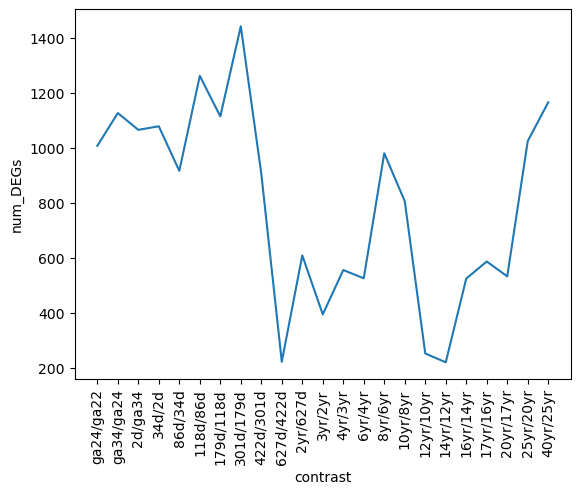

In [98]:
# Poor quality cells included
plt = sns.lineplot(significant, x='contrast', y='num_DEGs')
plt.tick_params(axis='x', rotation=90)

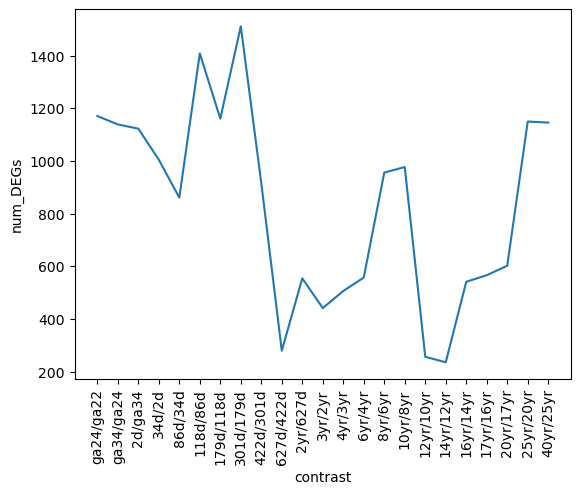

In [31]:
# Poor quality cells excluded
plt = sns.lineplot(significant, x='contrast', y='num_DEGs')
plt.tick_params(axis='x', rotation=90)

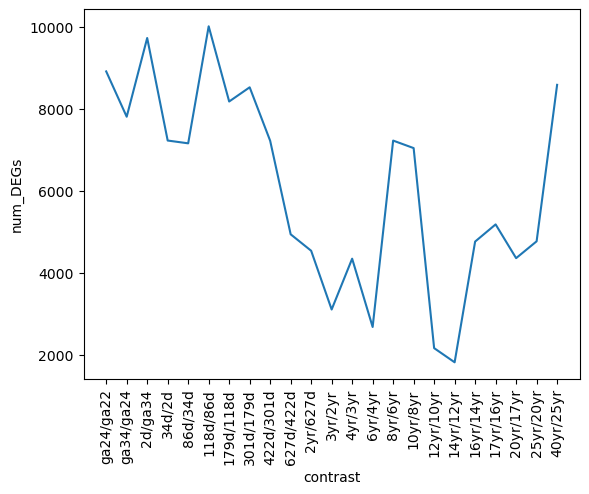

In [13]:
# Poor quality cells excluded, all genes
plt = sns.lineplot(significant, x='contrast', y='num_DEGs')
plt.tick_params(axis='x', rotation=90)

This is a staggering number of DEGs - in some cases over a third of all genes are flagged as significant. This may be because many are expressed so lowly that even small changes in expression are being flagged as significant - a problem which would be compounded by our inability to control for confounding factors, as changes due to these may cause shifts large enough to be flagged. Need to make this process more robust by doing full pairwise comparisons to allow checking for errant batches and clustering into stages. DEGs may also appear in multiple groups but we need a way to disambiguate between differences in fold change direction, i.e. identify when the same gene is significantly upregulated in one group versus significantly downregulated in another. 

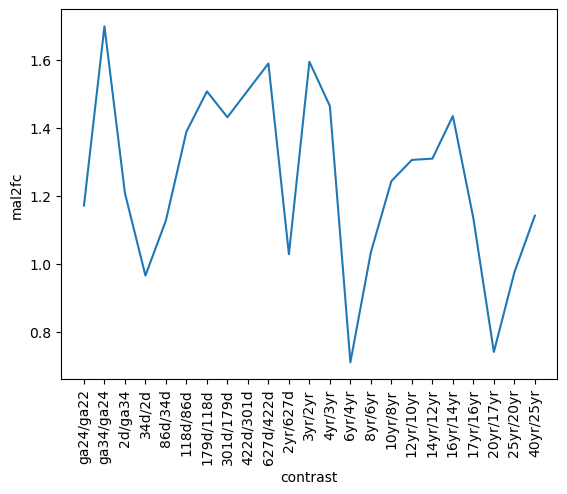

In [99]:
# Poor quality cells included
plt = sns.lineplot(significant, x='contrast', y='mal2fc')
plt.tick_params(axis='x', rotation=90)

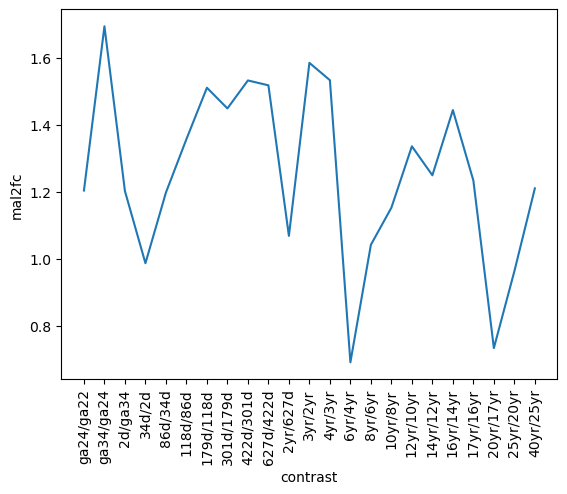

In [32]:
# Poor quality cells excluded
plt = sns.lineplot(significant, x='contrast', y='mal2fc')
plt.tick_params(axis='x', rotation=90)

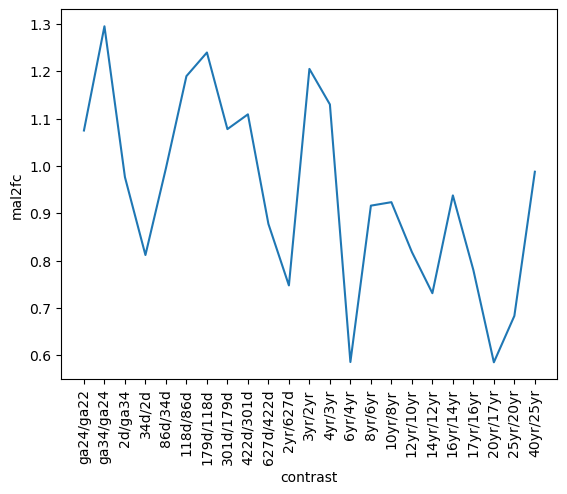

In [14]:
# Poor quality cells excluded, all genes
plt = sns.lineplot(significant, x='contrast', y='mal2fc')
plt.tick_params(axis='x', rotation=90)

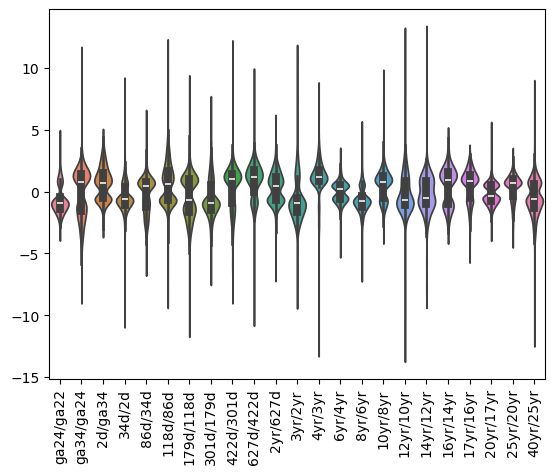

In [39]:
significant = {}
for res in results:
    significant[res] = results[res][results[res]['padj'] <= 0.05]['log2FoldChange']
plt = sns.violinplot(significant)
plt.tick_params(axis='x', rotation=90)

In [16]:
significant = pd.DataFrame(columns=['log2(num_DEGs/time)', 'confounders'])
for res in results:
    sig = results[res][results[res]['padj'] <= 0.05] # Get significant DEGs only
    num = len(sig)
    ages = res.split('/')
    time_diff = age_order_dict[ages[0]] - age_order_dict[ages[1]] # Calculate time difference between ages in years
    prev_age_confounders = bulk.obs[bulk.obs['age']==ages[0]][['Sex', 'chem', 'Race', 'Library Prep Lot', 'PMI']].drop_duplicates().values.tolist()[0]
    cur_age_confounders = bulk.obs[bulk.obs['age']==ages[1]][['Sex', 'chem', 'Race', 'Library Prep Lot', 'PMI']].drop_duplicates().values.tolist()[0]
    confounders = [c for c in cur_age_confounders if c not in prev_age_confounders] # Get confounding factors which differ between groups
    significant.loc[res] = (math.log2(num/time_diff), confounders)

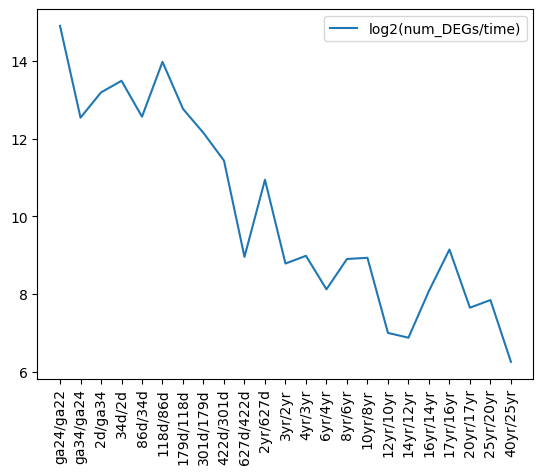

In [114]:
# Highly variable genes only
plt = sns.lineplot(significant)
plt.tick_params(axis='x', rotation=90)

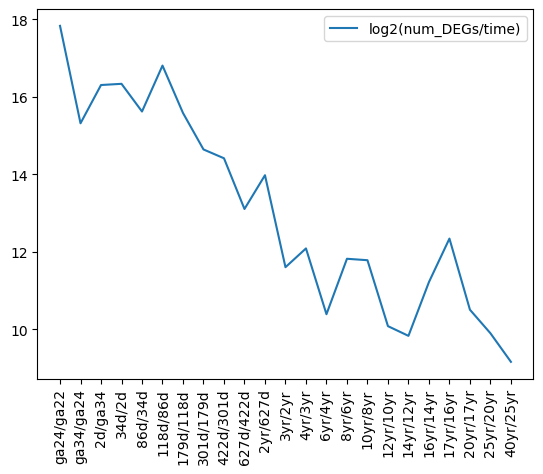

In [17]:
# All genes
plt = sns.lineplot(significant)
plt.tick_params(axis='x', rotation=90)

In [113]:
significant

,log2(num_DEGs/time),confounders
ga24/ga22,14.897923,[5]
ga34/ga24,12.536022,"[M, AA, 1, 9]"
2d/ga34,13.185463,"[2, 23]"
34d/2d,13.484732,"[F, v3, White, 4, 26]"
86d/34d,12.561182,"[v2, AA, 5, 5]"
118d/86d,13.972209,"[M, White, 6, 13]"
179d/118d,12.762168,"[F, AA, 21]"
301d/179d,12.143258,"[White, 7, 11]"
422d/301d,11.432093,"[M, 2, 18]"
627d/422d,8.956394,"[F, AA, 8, 20]"


Check overlap between significant DEGs in adjacent groups to see if the suite of genes is actually changing much or if there is a set of genes showing consistent changes across the breadth of development.

In [75]:
keys = [str(k) for k in results.keys()]
df_matrix = []
for res in results:
    props = []
    for rcomp in keys:
        if rcomp == res:
            props.append(1) # Perfect overlap with self
            continue
        sig1 = results[res][results[res]['padj'] <= 0.05].index
        sig2 = results[rcomp][results[rcomp]['padj'] <= 0.05].index
        overlap = [g for g in sig1 if g in sig2] # Get overlapping significant DEGs
        props.append(len(overlap)/len(sig1)) # Calculate overlap as proportion of DEGs in index list
    df_matrix.append(props)
overlaps = pd.DataFrame(df_matrix, index=keys, columns=keys)

<Axes: >

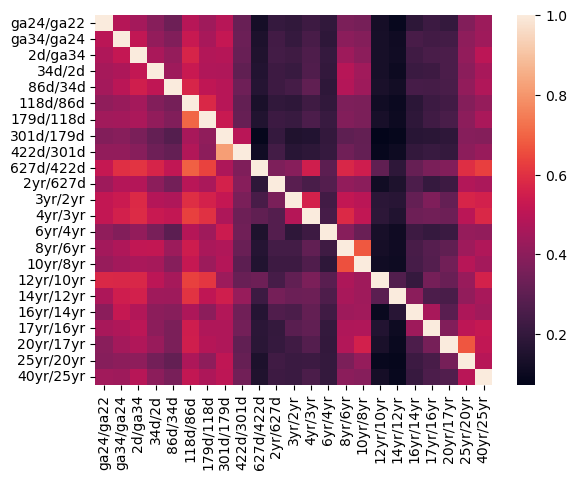

In [76]:
sns.heatmap(overlaps)

Possibly useful to pull out 'unique' DEGs from each group, e.g. those that don't overlap with neighbouring groups? This could tell us which specific processes are most affected at each stage but would remove any more general patterns from genes changing throughout development more broadly. These should be picked up in the stage-wise analysis though.

In [85]:
path = '/group/ll005/cmcphan/notebooks/analysis/results/herring/poor_quality_excl/go_term_enrichment/'
for res in results:
    sig = results[res][results[res]['padj'] <= 0.05].index.values
    df = sc.queries.enrich([str(g) for g in sig], org='hsapiens')
    ages = res.split('/')
    df.to_csv(str(path+'herring_'+ages[0]+'_'+ages[1]))

In [88]:
go_results = {}
path = '/group/ll005/cmcphan/notebooks/analysis/results/herring/poor_quality_excl/go_term_enrichment/' # Filepath for results directory
for file in os.listdir(path):
    full_path = str(path+file)
    comp = str(file.split('_')[1]+'/'+file.split('_')[2])
    go_results[comp] = pd.read_csv(full_path, index_col=0)

In [89]:
go_results['ga24/ga22']

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents
0,GO:BP,GO:0048731,system development,1.138890e-46,True,"""The process whose specific outcome is the pro...",3985,811,333,21017,0.410604,0.083563,query_1,"['GO:0007275', 'GO:0048856']"
1,GO:BP,GO:0048856,anatomical structure development,7.508178e-46,True,"""The biological process whose specific outcome...",5924,811,424,21017,0.522811,0.071573,query_1,['GO:0032502']
2,GO:BP,GO:0007275,multicellular organism development,5.348731e-44,True,"""The biological process whose specific outcome...",4658,811,361,21017,0.445129,0.077501,query_1,"['GO:0032501', 'GO:0048856']"
3,GO:BP,GO:0032502,developmental process,7.125057e-43,True,"""A biological process whose specific outcome i...",6478,811,442,21017,0.545006,0.068231,query_1,['GO:0008150']
4,GO:BP,GO:0032501,multicellular organismal process,7.138305e-42,True,"""Any biological process, occurring at the leve...",7234,811,472,21017,0.581998,0.065247,query_1,['GO:0008150']
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
728,GO:BP,GO:0022029,telencephalon cell migration,4.824083e-02,True,"""The orderly movement of a cell from one site ...",62,811,11,21017,0.013564,0.177419,query_1,"['GO:0021537', 'GO:0021885']"
729,GO:BP,GO:1903053,regulation of extracellular matrix organization,4.824083e-02,True,"""Any process that modulates the frequency, rat...",62,811,11,21017,0.013564,0.177419,query_1,"['GO:0030198', 'GO:0051128']"
730,GO:BP,GO:0070374,positive regulation of ERK1 and ERK2 cascade,4.842613e-02,True,"""Any process that activates or increases the f...",210,811,22,21017,0.027127,0.104762,query_1,"['GO:0043410', 'GO:0070371', 'GO:0070372']"
731,GO:MF,GO:0008047,enzyme activator activity,4.885559e-02,True,"""Binds to and increases the activity of an enz...",593,835,45,20196,0.053892,0.075885,query_1,"['GO:0030234', 'GO:0140677']"


Try to make our comparisons more robust - do full pairwise comparisons between all ages, which will allow us to see if any batches consistently fall out, e.g. are of poorer quality. This will allow us to better see how results might be affected by confounding factors, even though we aren't able to control for them directly, by checking how samples cluster together. Split DEGs into upregulated and downregulated groups to help us disambiguate when they appear in multiple comparisons - e.g. determine when a DEG appears in 2 different groups but is upregulated in one and downregulated in the other. 

In [3]:
%%R 
library(DESeq2)
library(sva)
library(pheatmap)

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Attaching package: ‘S4Vectors’

The following object is masked from ‘package:utils’:

    findMatches

The following objects are masked from ‘package:base’:

    expand.grid, I, unname

Loading required package: IRanges
Loading required package: GenomicRanges
Loading required package: GenomeInfoDb
Loading require

In [4]:
bulk = sc.get.aggregate(herring, by=['age', 'major_clust'], func='sum')
bulk = bulk[bulk.obs['major_clust']!='Poor-Quality'].copy() # Exclude poor quality cells
# Pseudobulk based on cell type and available cofactors for each age group
bulk.X = bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
# Convert non-string metadata to strings for import into R
for col in bulk.obs:
    if type(bulk.obs[col].values[0]) != str:
        bulk.obs[col] = [str(x) for x in bulk.obs[col]]
bulk

AnnData object with n_obs × n_vars = 373 × 26747
    obs: 'age', 'major_clust'
    var: 'gene_ids', 'feature_types', 'non-unique_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    layers: 'sum'

In [5]:
# Get order of age labels
age_order = herring.obs[['age', 'numerical_age']].sort_values(by='numerical_age').drop_duplicates().values
age_order

array([['ga22', -0.3452054794520548],
       ['ga24', -0.30684931506849317],
       ['ga34', -0.11506849315068493],
       ['2d', 0.005479452054794521],
       ['34d', 0.09315068493150686],
       ['86d', 0.2356164383561644],
       ['118d', 0.3232876712328767],
       ['179d', 0.4904109589041096],
       ['301d', 0.8246575342465754],
       ['422d', 1.1561643835616437],
       ['627d', 1.7178082191780821],
       ['2yr', 2.0],
       ['3yr', 3.0],
       ['4yr', 4.0],
       ['6yr', 6.0],
       ['8yr', 8.0],
       ['10yr', 10.0],
       ['12yr', 12.0],
       ['14yr', 14.0],
       ['16yr', 16.0],
       ['17yr', 17.0],
       ['20yr', 20.0],
       ['25yr', 25.0],
       ['40yr', 40.0]], dtype=object)

In [6]:
# Dictionary version for easily grabbing numerical age
age_order_dict = {}
for age, numerical_age in age_order:
    age_order_dict[age] = numerical_age

In [7]:
%%R -i bulk
bulk

class: SingleCellExperiment 
dim: 26747 373 
metadata(0):
assays(2): X sum
rownames(26747): RP11-34P13.7 AL627309.1 ... AC145205.1 CU459201.1
rowData names(15): gene_ids feature_types ... dispersions
  dispersions_norm
colnames(373): 2d_L2-3_CUX2 2d_L4_RORB ... ga34_Micro ga34_Vas
colData names(2): age major_clust
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [8]:
l = len(herring.obs['age'].drop_duplicates().values)
path = '/group/ll005/cmcphan/notebooks/analysis/results/herring/agewise/' # Filepath for results directory
for i in range(0, l-1):
    cur_age = age_order[i][0]
    print(('Batch # {} of {}').format(i, l-1))
    for c in range(i+1, l):
        comp_age = age_order[c][0]
        print(('Run # {} of {}: '+comp_age+' vs '+cur_age).format(c-i, l-1-i))
        # Grab only the data for the ages we're currently comparing and look for differentially expressed genes, controlling for cell type
        rpy2.robjects.r(str("data = bulk[,bulk$age %in% c('"+comp_age+"','"+cur_age+"')]"))             
        rpy2.robjects.r(str("dds = DESeqDataSet(bulk[,bulk$age %in% c('"+comp_age+"','"+cur_age+"')], design=~age+major_clust)"))
        rpy2.robjects.r("dds = DESeq(dds)")
        rpy2.robjects.r(str("res = results(dds, contrast=c('age','"+comp_age+"','"+cur_age+"'), format='DataFrame')"))
        # This runs the standard DESeq2 pipeline and generates a results dataframe with estimates for log2 fold changes
        # in the form log2(older/younger)
        rpy2.robjects.r(str("write.csv(res, file='"+path+'herring_'+comp_age+'_'+cur_age+"')")) # Write results to csv

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode



Batch # 0 of 23
Run # 1 of 23: ga24 vs ga22


R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than


Run # 2 of 23: ga34 vs ga22


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 3 of 23: 2d vs ga22


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 4 of 23: 34d vs ga22


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 5 of 23: 86d vs ga22


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 6 of 23: 118d vs ga22


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 7 of 23: 179d vs ga22


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 8 of 23: 301d vs ga22


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 9 of 23: 422d vs ga22


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 10 of 23: 627d vs ga22


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 11 of 23: 2yr vs ga22


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 12 of 23: 3yr vs ga22


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitTy

Run # 13 of 23: 4yr vs ga22


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels

Run # 14 of 23: 6yr vs ga22


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 15 of 23: 8yr vs ga22


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 16 of 23: 10yr vs ga22


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 17 of 23: 12yr vs ga22


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 18 of 23: 14yr vs ga22


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 19 of 23: 16yr vs ga22


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 20 of 23: 17yr vs ga22


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels

Run # 21 of 23: 20yr vs ga22


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 22 of 23: 25yr vs ga22


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 23 of 23: 40yr vs ga22


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Batch # 1 of 23
Run # 1 of 22: ga34 vs ga24


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 2 of 22: 2d vs ga24


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 3 of 22: 34d vs ga24


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 4 of 22: 86d vs ga24


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 5 of 22: 118d vs ga24


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 6 of 22: 179d vs ga24


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 7 of 22: 301d vs ga24


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels

Run # 8 of 22: 422d vs ga24


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 9 of 22: 627d vs ga24


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 10 of 22: 2yr vs ga24


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 11 of 22: 3yr vs ga24


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 12 of 22: 4yr vs ga24


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels

Run # 13 of 22: 6yr vs ga24


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 14 of 22: 8yr vs ga24


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 15 of 22: 10yr vs ga24


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 16 of 22: 12yr vs ga24


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 17 of 22: 14yr vs ga24


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 18 of 22: 16yr vs ga24


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 19 of 22: 17yr vs ga24


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 20 of 22: 20yr vs ga24


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 21 of 22: 25yr vs ga24


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 22 of 22: 40yr vs ga24


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Batch # 2 of 23
Run # 1 of 21: 2d vs ga34


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 2 of 21: 34d vs ga34


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 3 of 21: 86d vs ga34


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 4 of 21: 118d vs ga34


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 5 of 21: 179d vs ga34


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 6 of 21: 301d vs ga34


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 7 of 21: 422d vs ga34


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 8 of 21: 627d vs ga34


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 9 of 21: 2yr vs ga34


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitTy

Run # 10 of 21: 3yr vs ga34


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 11 of 21: 4yr vs ga34


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 12 of 21: 6yr vs ga34


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 13 of 21: 8yr vs ga34


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 14 of 21: 10yr vs ga34


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 15 of 21: 12yr vs ga34


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 16 of 21: 14yr vs ga34


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 17 of 21: 16yr vs ga34


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 18 of 21: 17yr vs ga34


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 19 of 21: 20yr vs ga34


R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to cons

Run # 20 of 21: 25yr vs ga34


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 21 of 21: 40yr vs ga34


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Batch # 3 of 23
Run # 1 of 20: 34d vs 2d


R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than


Run # 2 of 20: 86d vs 2d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 3 of 20: 118d vs 2d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 4 of 20: 179d vs 2d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 5 of 20: 301d vs 2d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 6 of 20: 422d vs 2d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 7 of 20: 627d vs 2d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 8 of 20: 2yr vs 2d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 9 of 20: 3yr vs 2d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 10 of 20: 4yr vs 2d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 11 of 20: 6yr vs 2d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 12 of 20: 8yr vs 2d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 13 of 20: 10yr vs 2d


R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than


Run # 14 of 20: 12yr vs 2d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 15 of 20: 14yr vs 2d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 16 of 20: 16yr vs 2d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 17 of 20: 17yr vs 2d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 18 of 20: 20yr vs 2d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 19 of 20: 25yr vs 2d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 20 of 20: 40yr vs 2d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Batch # 4 of 23
Run # 1 of 19: 86d vs 34d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 2 of 19: 118d vs 34d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 3 of 19: 179d vs 34d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 4 of 19: 301d vs 34d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 5 of 19: 422d vs 34d


R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to cons

Run # 6 of 19: 627d vs 34d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 7 of 19: 2yr vs 34d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 8 of 19: 3yr vs 34d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 9 of 19: 4yr vs 34d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 10 of 19: 6yr vs 34d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 11 of 19: 8yr vs 34d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 12 of 19: 10yr vs 34d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 13 of 19: 12yr vs 34d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 14 of 19: 14yr vs 34d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 15 of 19: 16yr vs 34d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 16 of 19: 17yr vs 34d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 17 of 19: 20yr vs 34d


R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than


Run # 18 of 19: 25yr vs 34d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 19 of 19: 40yr vs 34d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Batch # 5 of 23
Run # 1 of 18: 118d vs 86d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 2 of 18: 179d vs 86d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 3 of 18: 301d vs 86d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 4 of 18: 422d vs 86d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 5 of 18: 627d vs 86d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 6 of 18: 2yr vs 86d


R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to cons

Run # 7 of 18: 3yr vs 86d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 8 of 18: 4yr vs 86d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 9 of 18: 6yr vs 86d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 10 of 18: 8yr vs 86d


R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to cons

Run # 11 of 18: 10yr vs 86d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 12 of 18: 12yr vs 86d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 13 of 18: 14yr vs 86d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 14 of 18: 16yr vs 86d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 15 of 18: 17yr vs 86d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 16 of 18: 20yr vs 86d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 17 of 18: 25yr vs 86d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 18 of 18: 40yr vs 86d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Batch # 6 of 23
Run # 1 of 17: 179d vs 118d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 2 of 17: 301d vs 118d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 3 of 17: 422d vs 118d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 4 of 17: 627d vs 118d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 5 of 17: 2yr vs 118d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 6 of 17: 3yr vs 118d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 7 of 17: 4yr vs 118d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 8 of 17: 6yr vs 118d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 9 of 17: 8yr vs 118d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 10 of 17: 10yr vs 118d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 11 of 17: 12yr vs 118d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 12 of 17: 14yr vs 118d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 13 of 17: 16yr vs 118d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 14 of 17: 17yr vs 118d


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels

Run # 15 of 17: 20yr vs 118d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 16 of 17: 25yr vs 118d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 17 of 17: 40yr vs 118d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Batch # 7 of 23
Run # 1 of 16: 301d vs 179d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 2 of 16: 422d vs 179d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 3 of 16: 627d vs 179d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 4 of 16: 2yr vs 179d


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels

Run # 5 of 16: 3yr vs 179d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 6 of 16: 4yr vs 179d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 7 of 16: 6yr vs 179d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 8 of 16: 8yr vs 179d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 9 of 16: 10yr vs 179d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 10 of 16: 12yr vs 179d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 11 of 16: 14yr vs 179d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 12 of 16: 16yr vs 179d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 13 of 16: 17yr vs 179d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 14 of 16: 20yr vs 179d


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels

Run # 15 of 16: 25yr vs 179d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 16 of 16: 40yr vs 179d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Batch # 8 of 23
Run # 1 of 15: 422d vs 301d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 2 of 15: 627d vs 301d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 3 of 15: 2yr vs 301d


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels

Run # 4 of 15: 3yr vs 301d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 5 of 15: 4yr vs 301d


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels

Run # 6 of 15: 6yr vs 301d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 7 of 15: 8yr vs 301d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 8 of 15: 10yr vs 301d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 9 of 15: 12yr vs 301d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 10 of 15: 14yr vs 301d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 11 of 15: 16yr vs 301d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 12 of 15: 17yr vs 301d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 13 of 15: 20yr vs 301d


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels

Run # 14 of 15: 25yr vs 301d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 15 of 15: 40yr vs 301d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Batch # 9 of 23
Run # 1 of 14: 627d vs 422d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 2 of 14: 2yr vs 422d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 3 of 14: 3yr vs 422d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 4 of 14: 4yr vs 422d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 5 of 14: 6yr vs 422d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 6 of 14: 8yr vs 422d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 7 of 14: 10yr vs 422d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 8 of 14: 12yr vs 422d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 9 of 14: 14yr vs 422d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 10 of 14: 16yr vs 422d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 11 of 14: 17yr vs 422d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 12 of 14: 20yr vs 422d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 13 of 14: 25yr vs 422d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 14 of 14: 40yr vs 422d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Batch # 10 of 23
Run # 1 of 13: 2yr vs 627d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 2 of 13: 3yr vs 627d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 3 of 13: 4yr vs 627d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 4 of 13: 6yr vs 627d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 5 of 13: 8yr vs 627d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 6 of 13: 10yr vs 627d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 7 of 13: 12yr vs 627d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 8 of 13: 14yr vs 627d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 9 of 13: 16yr vs 627d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 10 of 13: 17yr vs 627d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 11 of 13: 20yr vs 627d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 12 of 13: 25yr vs 627d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 13 of 13: 40yr vs 627d


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Batch # 11 of 23
Run # 1 of 12: 3yr vs 2yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 2 of 12: 4yr vs 2yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 3 of 12: 6yr vs 2yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 4 of 12: 8yr vs 2yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 5 of 12: 10yr vs 2yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 6 of 12: 12yr vs 2yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 7 of 12: 14yr vs 2yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 8 of 12: 16yr vs 2yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 9 of 12: 17yr vs 2yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 10 of 12: 20yr vs 2yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 11 of 12: 25yr vs 2yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 12 of 12: 40yr vs 2yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Batch # 12 of 23
Run # 1 of 11: 4yr vs 3yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 2 of 11: 6yr vs 3yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 3 of 11: 8yr vs 3yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 4 of 11: 10yr vs 3yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 5 of 11: 12yr vs 3yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 6 of 11: 14yr vs 3yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 7 of 11: 16yr vs 3yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 8 of 11: 17yr vs 3yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 9 of 11: 20yr vs 3yr


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels

Run # 10 of 11: 25yr vs 3yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 11 of 11: 40yr vs 3yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Batch # 13 of 23
Run # 1 of 10: 6yr vs 4yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 2 of 10: 8yr vs 4yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 3 of 10: 10yr vs 4yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 4 of 10: 12yr vs 4yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 5 of 10: 14yr vs 4yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 6 of 10: 16yr vs 4yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 7 of 10: 17yr vs 4yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 8 of 10: 20yr vs 4yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 9 of 10: 25yr vs 4yr


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels

Run # 10 of 10: 40yr vs 4yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Batch # 14 of 23
Run # 1 of 9: 8yr vs 6yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 2 of 9: 10yr vs 6yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 3 of 9: 12yr vs 6yr


R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than


Run # 4 of 9: 14yr vs 6yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 5 of 9: 16yr vs 6yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 6 of 9: 17yr vs 6yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 7 of 9: 20yr vs 6yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 8 of 9: 25yr vs 6yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 9 of 9: 40yr vs 6yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Batch # 15 of 23
Run # 1 of 8: 10yr vs 8yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 2 of 8: 12yr vs 8yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 3 of 8: 14yr vs 8yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 4 of 8: 16yr vs 8yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 5 of 8: 17yr vs 8yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 6 of 8: 20yr vs 8yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 7 of 8: 25yr vs 8yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 8 of 8: 40yr vs 8yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Batch # 16 of 23
Run # 1 of 7: 12yr vs 10yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 2 of 7: 14yr vs 10yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 3 of 7: 16yr vs 10yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 4 of 7: 17yr vs 10yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 5 of 7: 20yr vs 10yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 6 of 7: 25yr vs 10yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 7 of 7: 40yr vs 10yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Batch # 17 of 23
Run # 1 of 6: 14yr vs 12yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 2 of 6: 16yr vs 12yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 3 of 6: 17yr vs 12yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 4 of 6: 20yr vs 12yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 5 of 6: 25yr vs 12yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 6 of 6: 40yr vs 12yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Batch # 18 of 23
Run # 1 of 5: 16yr vs 14yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Run # 2 of 5: 17yr vs 14yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 3 of 5: 20yr vs 14yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 4 of 5: 25yr vs 14yr


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels

Run # 5 of 5: 40yr vs 14yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit wa

Batch # 19 of 23
Run # 1 of 4: 17yr vs 16yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 2 of 4: 20yr vs 16yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 3 of 4: 25yr vs 16yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 4 of 4: 40yr vs 16yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Batch # 20 of 23
Run # 1 of 3: 20yr vs 17yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 2 of 3: 25yr vs 17yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 3 of 3: 40yr vs 17yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Batch # 21 of 23
Run # 1 of 2: 25yr vs 20yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Run # 2 of 2: 40yr vs 20yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

Batch # 22 of 23
Run # 1 of 1: 40yr vs 25yr


R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating size factors

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]:   Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) 

In [9]:
results = {}
path = '/group/ll005/cmcphan/notebooks/analysis/results/herring/agewise/' # Filepath for results directory
for file in os.listdir(path):
    if os.path.isdir(str(path+file)):
        continue # Don't try to read directories
    full_path = str(path+file)
    comp = str(file.split('_')[1]+'/'+file.split('_')[2])
    results[comp] = pd.read_csv(full_path, index_col=0).sort_values(by='padj')

In [10]:
df_matrix = []
LFC_CUTOFF = 1
age_order_list = list(age_order_dict.keys())
for res_idx in range(0, len(age_order_dict.keys())):
    counts = []
    rcomp_idx = 0
    for rcomp_idx in range(0, len(age_order_dict.keys())):
        if rcomp_idx == res_idx:
            counts.append(0) # No comparison with self
            rcomp_idx += 1
            continue
        elif rcomp_idx < res_idx: # Lower portion of heatmap - should display downregulated DEG count
            res = str(age_order_list[res_idx]+'/'+age_order_list[rcomp_idx])
            sig = results[res][results[res]['padj'] <= 0.05]
            sig = sig[sig['log2FoldChange'] >= LFC_CUTOFF]
            rcomp_idx += 1
            counts.append(-len(sig)) # Negative values for downregulated counts
        elif rcomp_idx > res_idx: # Upper portion of heatmap - should display upregulated DEG count
            res = str(age_order_list[rcomp_idx]+'/'+age_order_list[res_idx])
            sig = results[res][results[res]['padj'] <= 0.05]
            sig = sig[sig['log2FoldChange'] <= -LFC_CUTOFF]
            rcomp_idx += 1
            counts.append(len(sig))
    df_matrix.append(counts)
comps = pd.DataFrame(df_matrix, index=age_order_list, columns=age_order_list)

<Axes: >

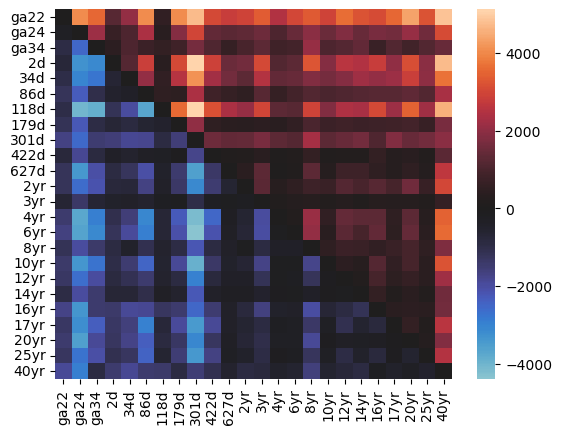

In [11]:
sns.heatmap(comps, cmap='icefire', center=0)

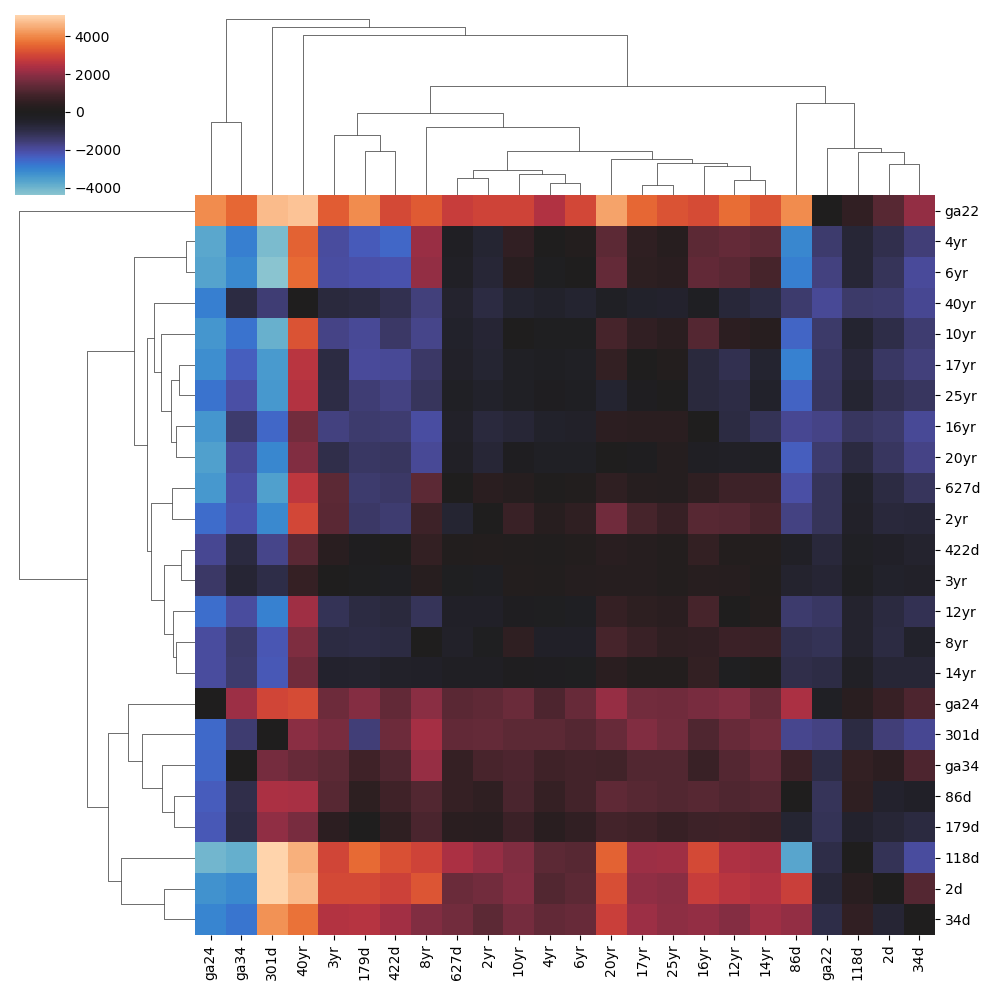

In [12]:
sns.clustermap(comps, cmap='icefire', center=0)

### Sepp Mouse data
Check whether this approach works well enough for mouse staging

In [9]:
# Use only the cell types which we have verified and can trust
accepted_cell_types = ['Purkinje', 'interneuron', 'VZ_neuroblast', 'UBC', 'GC', 'NTZ_neuroblast', 'astroglia', 'oligo']
sepp_mouse_filtered = sepp_mouse[sepp_mouse.obs['cell_type'].isin(accepted_cell_types)]
bulk = sc.get.aggregate(sepp_mouse_filtered, by=['age', 'cell_type'], func='sum')
# Pseudobulk based on cell type
bulk.X = bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
# Convert non-string metadata to strings for import into R
for col in bulk.obs:
    if type(bulk.obs[col].values[0]) != str:
        bulk.obs[col] = [str(x) for x in bulk.obs[col]]
bulk

AnnData object with n_obs × n_vars = 78 × 20424
    obs: 'age', 'cell_type'
    var: 'ensembl_gene_id', 'gene_symbol', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    layers: 'sum'

In [10]:
# Get order of age labels
age_order = sepp_mouse.obs[['age', 'numerical_age']].sort_values(by='numerical_age').drop_duplicates().values
age_order

array([['EM10.5', -0.026027397260273973],
       ['EM11.5', -0.023287671232876714],
       ['EM12.5', -0.02054794520547945],
       ['EM13.5', -0.01780821917808219],
       ['EM14.5', -0.015068493150684932],
       ['EM15.5', -0.012328767123287671],
       ['EM17.5', -0.00684931506849315],
       ['P0', 0.0],
       ['P4', 0.010958904109589041],
       ['P7', 0.019178082191780823],
       ['P14', 0.038356164383561646],
       ['9w', 0.1726027397260274]], dtype=object)

In [11]:
# Dictionary version for easily grabbing numerical age
age_order_dict = {}
for age, numerical_age in age_order:
    age_order_dict[age] = numerical_age

In [12]:
%%R -i bulk
bulk

class: SingleCellExperiment 
dim: 20424 78 
metadata(0):
assays(2): X sum
rownames(20424): ENSMUSG00000051951 ENSMUSG00000089699 ...
  ENSMUSG00000045932 ENSMUSG00000092369
rowData names(14): ensembl_gene_id gene_symbol ... variances
  variances_norm
colnames(78): 9w_GC 9w_Purkinje ... P14_interneuron P14_oligo
colData names(2): age cell_type
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [13]:
l = len(sepp_mouse.obs['age'].drop_duplicates().values)
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/' # Filepath for results directory
for i in range(0, l-1):
    cur_age = age_order[i][0]
    print(('Batch # {} of {}').format(i, l-1))
    for c in range(i+1, l):
        comp_age = age_order[c][0]
        print(('Run # {} of {}: '+comp_age+' vs '+cur_age).format(c-i, l-1-i))
        # Grab only the data for the ages we're currently comparing and look for differentially expressed genes, controlling for cell type
        rpy2.robjects.r(str("data = bulk[,bulk$age %in% c('"+comp_age+"','"+cur_age+"')]"))             
        rpy2.robjects.r(str("dds = DESeqDataSet(bulk[,bulk$age %in% c('"+comp_age+"','"+cur_age+"')], design=~age+cell_type)"))
        rpy2.robjects.r("dds = DESeq(dds)")
        rpy2.robjects.r(str("res = results(dds, contrast=c('age','"+comp_age+"','"+cur_age+"'), format='DataFrame')"))
        # This runs the standard DESeq2 pipeline and generates a results dataframe with estimates for log2 fold changes
        # in the form log2(older/younger)
        rpy2.robjects.r(str("write.csv(res, file='"+path+'sepp_mouse_'+comp_age+'_'+cur_age+"')")) # Write results to csv

R[write to console]: renaming the first element in assays to 'counts'



Batch # 0 of 11
Run # 1 of 11: EM11.5 vs EM10.5


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 11: EM12.5 vs EM10.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 3 of 11: EM13.5 vs EM10.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 4 of 11: EM14.5 vs EM10.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 5 of 11: EM15.5 vs EM10.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 6 of 11: EM17.5 vs EM10.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode



Run # 7 of 11: P0 vs EM10.5


R[write to console]: factor levels were dropped which had no samples

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 8 of 11: P4 vs EM10.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 9 of 11: P7 vs EM10.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode



Run # 10 of 11: P14 vs EM10.5


R[write to console]: factor levels were dropped which had no samples

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 11 of 11: 9w vs EM10.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 1 of 11
Run # 1 of 10: EM12.5 vs EM11.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 10: EM13.5 vs EM11.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode



Run # 3 of 10: EM14.5 vs EM11.5


R[write to console]: factor levels were dropped which had no samples

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 4 of 10: EM15.5 vs EM11.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 5 of 10: EM17.5 vs EM11.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 6 of 10: P0 vs EM11.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode



Run # 7 of 10: P4 vs EM11.5


R[write to console]: factor levels were dropped which had no samples

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 8 of 10: P7 vs EM11.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 9 of 10: P14 vs EM11.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 10 of 10: 9w vs EM11.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 2 of 11
Run # 1 of 9: EM13.5 vs EM12.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'



Run # 2 of 9: EM14.5 vs EM12.5


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 3 of 9: EM15.5 vs EM12.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 4 of 9: EM17.5 vs EM12.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 5 of 9: P0 vs EM12.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 6 of 9: P4 vs EM12.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



Run # 7 of 9: P7 vs EM12.5


R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 8 of 9: P14 vs EM12.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode



Run # 9 of 9: 9w vs EM12.5


R[write to console]: factor levels were dropped which had no samples

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 3 of 11
Run # 1 of 8: EM14.5 vs EM13.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 8: EM15.5 vs EM13.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 3 of 8: EM17.5 vs EM13.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 4 of 8: P0 vs EM13.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'



Run # 5 of 8: P4 vs EM13.5


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 6 of 8: P7 vs EM13.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 7 of 8: P14 vs EM13.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 8 of 8: 9w vs EM13.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 4 of 11
Run # 1 of 7: EM15.5 vs EM14.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 7: EM17.5 vs EM14.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 3 of 7: P0 vs EM14.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 4 of 7: P4 vs EM14.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 5 of 7: P7 vs EM14.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 6 of 7: P14 vs EM14.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 7 of 7: 9w vs EM14.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 5 of 11
Run # 1 of 6: EM17.5 vs EM15.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 6: P0 vs EM15.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 3 of 6: P4 vs EM15.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 4 of 6: P7 vs EM15.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 5 of 6: P14 vs EM15.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 6 of 6: 9w vs EM15.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 6 of 11
Run # 1 of 5: P0 vs EM17.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 5: P4 vs EM17.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 3 of 5: P7 vs EM17.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 4 of 5: P14 vs EM17.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 5 of 5: 9w vs EM17.5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 7 of 11
Run # 1 of 4: P4 vs P0


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 4: P7 vs P0


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 3 of 4: P14 vs P0


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 4 of 4: 9w vs P0


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 8 of 11
Run # 1 of 3: P7 vs P4


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 3: P14 vs P4


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 3 of 3: 9w vs P4


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 9 of 11
Run # 1 of 2: P14 vs P7


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 2: 9w vs P7


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 10 of 11
Run # 1 of 1: 9w vs P14


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [14]:
results = {}
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/mouse/agewise/' # Filepath for results directory
for file in os.listdir(path):
    if os.path.isdir(str(path+file)):
        continue # Don't try to read directories
    full_path = str(path+file)
    comp = str(file.split('_')[2]+'/'+file.split('_')[3])
    results[comp] = pd.read_csv(full_path, index_col=0).sort_values(by='padj')

In [15]:
df_matrix = []
LFC_CUTOFF = 1
age_order_list = list(age_order_dict.keys())
for res_idx in range(0, len(age_order_dict.keys())):
    counts = []
    rcomp_idx = 0
    for rcomp_idx in range(0, len(age_order_dict.keys())):
        if rcomp_idx == res_idx:
            counts.append(0) # No comparison with self
            rcomp_idx += 1
            continue
        elif rcomp_idx < res_idx: # Lower portion of heatmap - should display downregulated DEG count
            res = str(age_order_list[res_idx]+'/'+age_order_list[rcomp_idx])
            sig = results[res][results[res]['padj'] <= 0.05]
            sig = sig[sig['log2FoldChange'] >= LFC_CUTOFF]
            rcomp_idx += 1
            counts.append(-len(sig)) # Negative values for downregulated counts
        elif rcomp_idx > res_idx: # Upper portion of heatmap - should display upregulated DEG count
            res = str(age_order_list[rcomp_idx]+'/'+age_order_list[res_idx])
            sig = results[res][results[res]['padj'] <= 0.05]
            sig = sig[sig['log2FoldChange'] <= -LFC_CUTOFF]
            rcomp_idx += 1
            counts.append(len(sig))
    df_matrix.append(counts)
comps = pd.DataFrame(df_matrix, index=age_order_list, columns=age_order_list)

<Axes: >

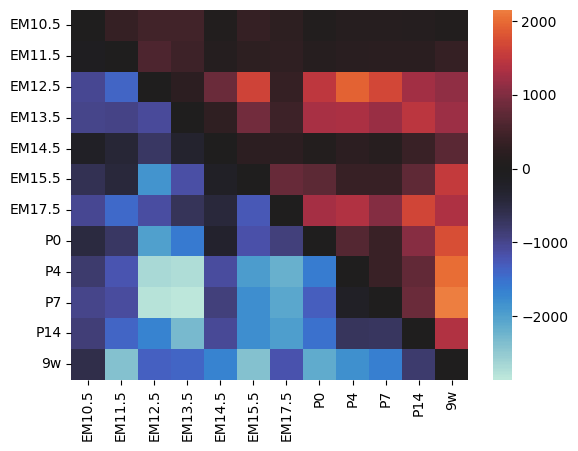

In [16]:
sns.heatmap(comps, cmap='icefire', center=0)

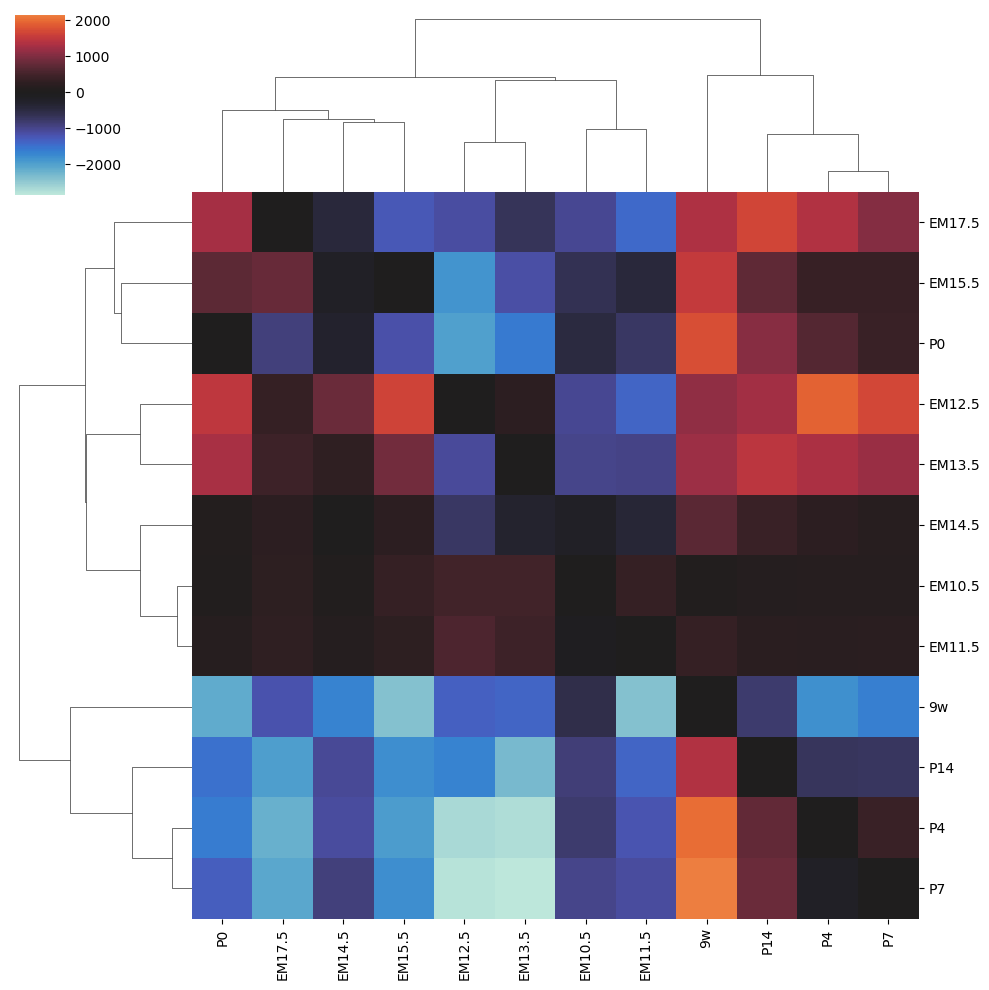

In [17]:
sns.clustermap(comps, cmap='icefire', center=0)

### Sepp Opossum

In [18]:
accepted_cell_types = ['Purkinje', 'interneuron', 'VZ_neuroblast', 'UBC', 'GC', 'NTZ_neuroblast', 'astroglia', 'oligo']
sepp_opossum_filtered = sepp_opossum[sepp_opossum.obs['cell_type'].isin(accepted_cell_types)]
bulk = sc.get.aggregate(sepp_opossum_filtered, by=['age', 'cell_type'], func='sum')
# Pseudobulk based on cell type
bulk.X = bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
# Convert non-string metadata to strings for import into R
for col in bulk.obs:
    if type(bulk.obs[col].values[0]) != str:
        bulk.obs[col] = [str(x) for x in bulk.obs[col]]
bulk

AnnData object with n_obs × n_vars = 64 × 28773
    obs: 'age', 'cell_type'
    var: 'ensembl_gene_id', 'gene_symbol', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    layers: 'sum'

In [19]:
# Get order of age labels
age_order = sepp_opossum.obs[['age', 'numerical_age']].sort_values(by='numerical_age').drop_duplicates().values
age_order

array([['EO14', -0.0027397260273972603],
       ['P1', 0.0027397260273972603],
       ['P4', 0.010958904109589041],
       ['P5', 0.0136986301369863],
       ['P14', 0.038356164383561646],
       ['P21', 0.057534246575342465],
       ['P42', 0.11506849315068493],
       ['P60', 0.1643835616438356],
       ['14m', 1.1666666666666667],
       ['16m', 1.3333333333333333]], dtype=object)

In [20]:
# Dictionary version for easily grabbing numerical age
age_order_dict = {}
for age, numerical_age in age_order:
    age_order_dict[age] = numerical_age

In [21]:
%%R -i bulk
bulk

class: SingleCellExperiment 
dim: 28773 64 
metadata(0):
assays(2): X sum
rownames(28773): ENSMODG00000013483 ENSMODG00000027972 ... XLOC_071337
  XLOC_072138
rowData names(14): ensembl_gene_id gene_symbol ... variances
  variances_norm
colnames(64): 14m_GC 14m_Purkinje ... P60_interneuron P60_oligo
colData names(2): age cell_type
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [22]:
l = len(sepp_opossum.obs['age'].drop_duplicates().values)
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/' # Filepath for results directory
for i in range(0, l-1):
    cur_age = age_order[i][0]
    print(('Batch # {} of {}').format(i, l-1))
    for c in range(i+1, l):
        comp_age = age_order[c][0]
        print(('Run # {} of {}: '+comp_age+' vs '+cur_age).format(c-i, l-1-i))
        # Grab only the data for the ages we're currently comparing and look for differentially expressed genes, controlling for cell type
        rpy2.robjects.r(str("data = bulk[,bulk$age %in% c('"+comp_age+"','"+cur_age+"')]"))             
        rpy2.robjects.r(str("dds = DESeqDataSet(bulk[,bulk$age %in% c('"+comp_age+"','"+cur_age+"')], design=~age+cell_type)"))
        rpy2.robjects.r("dds = DESeq(dds)")
        rpy2.robjects.r(str("res = results(dds, contrast=c('age','"+comp_age+"','"+cur_age+"'), format='DataFrame')"))
        # This runs the standard DESeq2 pipeline and generates a results dataframe with estimates for log2 fold changes
        # in the form log2(older/younger)
        rpy2.robjects.r(str("write.csv(res, file='"+path+'sepp_opossum_'+comp_age+'_'+cur_age+"')")) # Write results to csv

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode



Batch # 0 of 9
Run # 1 of 9: P1 vs EO14


R[write to console]: factor levels were dropped which had no samples

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 9: P4 vs EO14


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 3 of 9: P5 vs EO14


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 4 of 9: P14 vs EO14


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 5 of 9: P21 vs EO14


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 6 of 9: P42 vs EO14


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 7 of 9: P60 vs EO14


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 8 of 9: 14m vs EO14


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 9 of 9: 16m vs EO14


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 1 of 9
Run # 1 of 8: P4 vs P1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 8: P5 vs P1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 3 of 8: P14 vs P1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 4 of 8: P21 vs P1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 5 of 8: P42 vs P1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 6 of 8: P60 vs P1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 7 of 8: 14m vs P1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 8 of 8: 16m vs P1


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 2 of 9
Run # 1 of 7: P5 vs P4


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 7: P14 vs P4


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 3 of 7: P21 vs P4


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 4 of 7: P42 vs P4


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 5 of 7: P60 vs P4


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'



Run # 6 of 7: 14m vs P4


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'



Run # 7 of 7: 16m vs P4


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 3 of 9
Run # 1 of 6: P14 vs P5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 6: P21 vs P5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 3 of 6: P42 vs P5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 4 of 6: P60 vs P5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 5 of 6: 14m vs P5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 6 of 6: 16m vs P5


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 4 of 9
Run # 1 of 5: P21 vs P14


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 5: P42 vs P14


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 3 of 5: P60 vs P14


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 4 of 5: 14m vs P14


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 5 of 5: 16m vs P14


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'



Batch # 5 of 9
Run # 1 of 4: P42 vs P21


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 4: P60 vs P21


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 3 of 4: 14m vs P21


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'



Run # 4 of 4: 16m vs P21


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 6 of 9
Run # 1 of 3: P60 vs P42


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 3: 14m vs P42


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 3 of 3: 16m vs P42


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 7 of 9
Run # 1 of 2: 14m vs P60


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 2: 16m vs P60


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 8 of 9
Run # 1 of 1: 16m vs 14m


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [23]:
results = {}
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/opossum/agewise/' # Filepath for results directory
for file in os.listdir(path):
    if os.path.isdir(str(path+file)):
        continue # Don't try to read directories
    full_path = str(path+file)
    comp = str(file.split('_')[2]+'/'+file.split('_')[3])
    results[comp] = pd.read_csv(full_path, index_col=0).sort_values(by='padj')

In [24]:
df_matrix = []
LFC_CUTOFF = 1
age_order_list = list(age_order_dict.keys())
for res_idx in range(0, len(age_order_dict.keys())):
    counts = []
    rcomp_idx = 0
    for rcomp_idx in range(0, len(age_order_dict.keys())):
        if rcomp_idx == res_idx:
            counts.append(0) # No comparison with self
            rcomp_idx += 1
            continue
        elif rcomp_idx < res_idx: # Lower portion of heatmap - should display downregulated DEG count
            res = str(age_order_list[res_idx]+'/'+age_order_list[rcomp_idx])
            sig = results[res][results[res]['padj'] <= 0.05]
            sig = sig[sig['log2FoldChange'] >= LFC_CUTOFF]
            rcomp_idx += 1
            counts.append(-len(sig)) # Negative values for downregulated counts
        elif rcomp_idx > res_idx: # Upper portion of heatmap - should display upregulated DEG count
            res = str(age_order_list[rcomp_idx]+'/'+age_order_list[res_idx])
            sig = results[res][results[res]['padj'] <= 0.05]
            sig = sig[sig['log2FoldChange'] <= -LFC_CUTOFF]
            rcomp_idx += 1
            counts.append(len(sig))
    df_matrix.append(counts)
comps = pd.DataFrame(df_matrix, index=age_order_list, columns=age_order_list)

<Axes: >

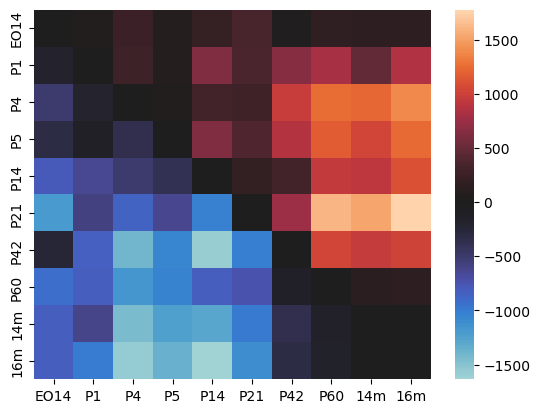

In [25]:
sns.heatmap(comps, cmap='icefire', center=0)

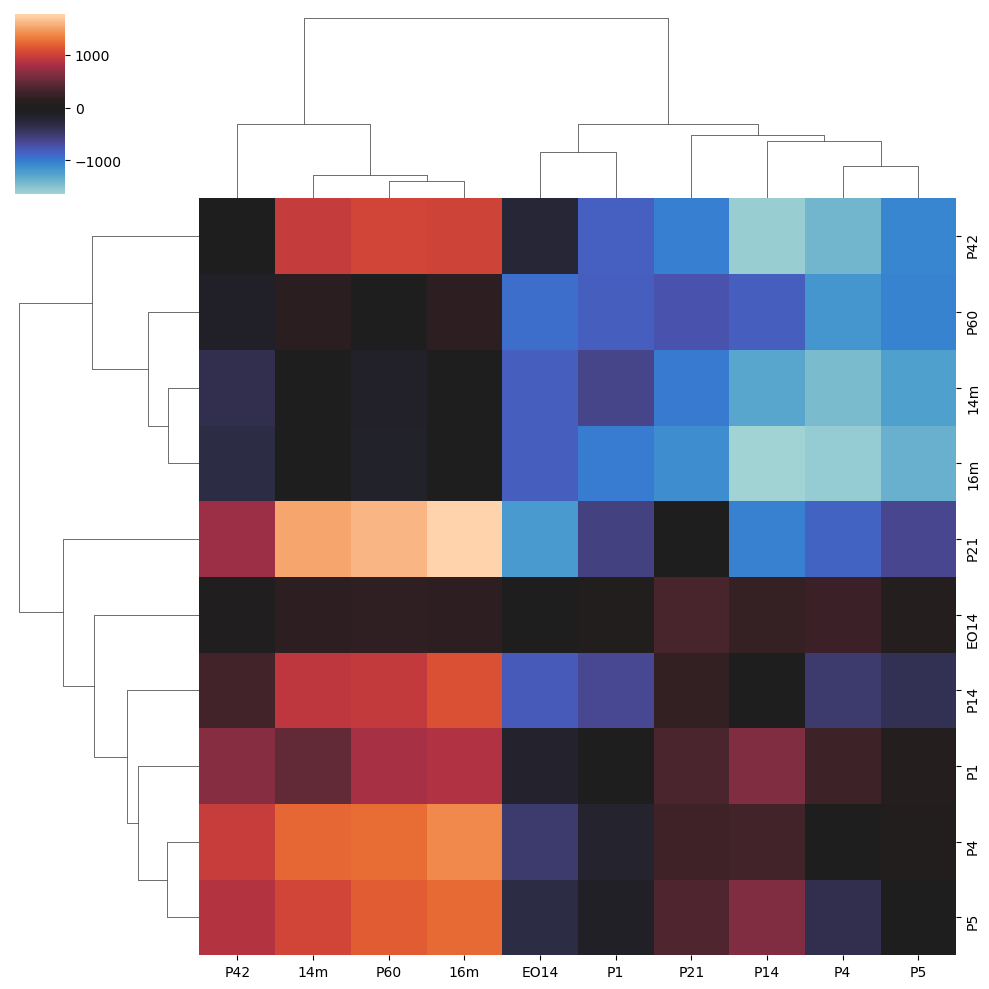

In [26]:
sns.clustermap(comps, cmap='icefire', center=0)

### Sepp Human

In [14]:
# Use highly variable genes only
accepted_cell_types = ['Purkinje', 'interneuron', 'VZ_neuroblast', 'UBC', 'GC', 'NTZ_neuroblast', 'astroglia', 'oligo']
sepp_human_filtered = sepp_human[sepp_human.obs['cell_type'].isin(accepted_cell_types)]
# Exclude batches with a NaN age
sepp_human_filtered = sepp_human_filtered[~sepp_human_filtered.obs['batch'].isin(['SN035', 'SN308'])]
bulk = sc.get.aggregate(sepp_human_filtered, by=['age', 'cell_type'], func='sum')
# Pseudobulk based on cell type
bulk.X = bulk.layers['sum'] # Put the aggregated counts into the base X layer for DeSeq2
# Convert non-string metadata to strings for import into R
for col in bulk.obs:
    if type(bulk.obs[col].values[0]) != str:
        bulk.obs[col] = [str(x) for x in bulk.obs[col]]
bulk

AnnData object with n_obs × n_vars = 76 × 27260
    obs: 'age', 'cell_type'
    var: 'ensembl_gene_id', 'gene_symbol', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    layers: 'sum'

In [15]:
# Get order of age labels
age_order = sepp_human_filtered.obs[['age', 'numerical_age']].sort_values(by='numerical_age').drop_duplicates().values
age_order

array([['7wpc', -0.5945205479452055],
       ['8wpc', -0.5753424657534246],
       ['9wpc', -0.5561643835616439],
       ['11wpc', -0.5178082191780822],
       ['17wpc', -0.40273972602739727],
       ['20wpc', -0.3452054794520548],
       ['5d', 0.0136986301369863],
       ['6m', 0.5],
       ['7m', 0.5833333333333334],
       ['9m', 0.75],
       ['2.8yr', 2.8],
       ['3.5yr', 3.5],
       ['42yr', 42.0],
       ['46yr', 46.0]], dtype=object)

In [16]:
# Dictionary version for easily grabbing numerical age
age_order_dict = {}
for age, numerical_age in age_order:
    age_order_dict[age] = numerical_age

In [17]:
%%R -i bulk
bulk

class: SingleCellExperiment 
dim: 27260 76 
metadata(0):
assays(2): X sum
rownames(27260): ENSG00000237094 ENSG00000230021 ... ENSG00000232464
  ENSG00000227895
rowData names(14): ensembl_gene_id gene_symbol ... variances
  variances_norm
colnames(76): 2.8yr_GC 2.8yr_Purkinje ... 46yr_interneuron 46yr_oligo
colData names(2): age cell_type
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):


In [19]:
l = len(sepp_human_filtered.obs['age'].drop_duplicates().values)
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/agewise/' # Filepath for results directory
unavailable = []
for i in range(0, l-1):
    cur_age = age_order[i][0]
    print(('Batch # {} of {}').format(i, l-1))
    for c in range(i+1, l):
        comp_age = age_order[c][0]
        print(('Run # {} of {}: '+comp_age+' vs '+cur_age).format(c-i, l-1-i))
        # Grab only the data for the ages we're currently comparing and look for differentially expressed genes, controlling for cell type
        rpy2.robjects.r(str("data = bulk[,bulk$age %in% c('"+comp_age+"','"+cur_age+"')]"))             
        rpy2.robjects.r(str("dds = DESeqDataSet(bulk[,bulk$age %in% c('"+comp_age+"','"+cur_age+"')], design=~age+cell_type)"))
        # Due to massive swings in cell type proportions, some comparisons are not possible as we do not have certain cell types
        # in both samples. Attempt each comparison and simply skip over any that produce a runtime error.
        try:
            rpy2.robjects.r("dds = DESeq(dds)")
        except:
            unavailable.append(str(comp_age+'/'+cur_age))
            continue
        rpy2.robjects.r(str("res = results(dds, contrast=c('age','"+comp_age+"','"+cur_age+"'), format='DataFrame')"))
        # This runs the standard DESeq2 pipeline and generates a results dataframe with estimates for log2 fold changes
        # in the form log2(older/younger)
        rpy2.robjects.r(str("write.csv(res, file='"+path+'sepp_human_'+comp_age+'_'+cur_age+"')")) # Write results to csv

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 0 of 13
Run # 1 of 13: 8wpc vs 7wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 13: 9wpc vs 7wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 3 of 13: 11wpc vs 7wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'



Run # 4 of 13: 17wpc vs 7wpc


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 5 of 13: 20wpc vs 7wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 6 of 13: 5d vs 7wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 7 of 13: 6m vs 7wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 8 of 13: 7m vs 7wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 9 of 13: 9m vs 7wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 10 of 13: 2.8yr vs 7wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 11 of 13: 3.5yr vs 7wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: Error in checkForExperimentalReplicates(object, modelMatrix) : 

  The design matrix has the same number of samples and coefficients to fit,
  so estimation of dispersion is not possible. Treating samples
  as replicates was deprecated in v1.20 and no longer supported since v1.22.


R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 12 of 13: 42yr vs 7wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 13 of 13: 46yr vs 7wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 1 of 13
Run # 1 of 12: 9wpc vs 8wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 12: 11wpc vs 8wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'



Run # 3 of 12: 17wpc vs 8wpc


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 4 of 12: 20wpc vs 8wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 5 of 12: 5d vs 8wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



Run # 6 of 12: 6m vs 8wpc


R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 7 of 12: 7m vs 8wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 8 of 12: 9m vs 8wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 9 of 12: 2.8yr vs 8wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 10 of 12: 3.5yr vs 8wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 11 of 12: 42yr vs 8wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 12 of 12: 46yr vs 8wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 2 of 13
Run # 1 of 11: 11wpc vs 9wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 11: 17wpc vs 9wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 3 of 11: 20wpc vs 9wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 4 of 11: 5d vs 9wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 5 of 11: 6m vs 9wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 6 of 11: 7m vs 9wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 7 of 11: 9m vs 9wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 8 of 11: 2.8yr vs 9wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 9 of 11: 3.5yr vs 9wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 10 of 11: 42yr vs 9wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 11 of 11: 46yr vs 9wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 3 of 13
Run # 1 of 10: 17wpc vs 11wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 10: 20wpc vs 11wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'



Run # 3 of 10: 5d vs 11wpc


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 4 of 10: 6m vs 11wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 5 of 10: 7m vs 11wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 6 of 10: 9m vs 11wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 7 of 10: 2.8yr vs 11wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 8 of 10: 3.5yr vs 11wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 9 of 10: 42yr vs 11wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 10 of 10: 46yr vs 11wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 4 of 13
Run # 1 of 9: 20wpc vs 17wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 9: 5d vs 17wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 3 of 9: 6m vs 17wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 4 of 9: 7m vs 17wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 5 of 9: 9m vs 17wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 6 of 9: 2.8yr vs 17wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 7 of 9: 3.5yr vs 17wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 8 of 9: 42yr vs 17wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'



Run # 9 of 9: 46yr vs 17wpc


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 5 of 13
Run # 1 of 8: 5d vs 20wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 8: 6m vs 20wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 3 of 8: 7m vs 20wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'



Run # 4 of 8: 9m vs 20wpc


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 5 of 8: 2.8yr vs 20wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 6 of 8: 3.5yr vs 20wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 7 of 8: 42yr vs 20wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 8 of 8: 46yr vs 20wpc


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 6 of 13
Run # 1 of 7: 6m vs 5d


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'



Run # 2 of 7: 7m vs 5d


R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples

R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 3 of 7: 9m vs 5d


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 4 of 7: 2.8yr vs 5d


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 5 of 7: 3.5yr vs 5d


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 6 of 7: 42yr vs 5d


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 7 of 7: 46yr vs 5d


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 7 of 13
Run # 1 of 6: 7m vs 6m


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 6: 9m vs 6m


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 3 of 6: 2.8yr vs 6m


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 4 of 6: 3.5yr vs 6m


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 5 of 6: 42yr vs 6m


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 6 of 6: 46yr vs 6m


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 8 of 13
Run # 1 of 5: 9m vs 7m


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 5: 2.8yr vs 7m


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 3 of 5: 3.5yr vs 7m


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 4 of 5: 42yr vs 7m


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 5 of 5: 46yr vs 7m


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 9 of 13
Run # 1 of 4: 2.8yr vs 9m


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 4: 3.5yr vs 9m


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 3 of 4: 42yr vs 9m


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 4 of 4: 46yr vs 9m


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 10 of 13
Run # 1 of 3: 3.5yr vs 2.8yr


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 3: 42yr vs 2.8yr


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: -- note: fitType='parametric', but the dispersion trend was not well captured by the
   function: y = a/x + b, and a local regression fit was automatically substituted.
   specify fitType='local' or 'mean' to avoid this message next time.

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 3 of 3: 46yr vs 2.8yr


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 11 of 13
Run # 1 of 2: 42yr vs 3.5yr


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Run # 2 of 2: 46yr vs 3.5yr


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing

R[write to console]: renaming the first element in assays to 'counts'

R[write to console]: converting counts to integer mode

R[write to console]: factor levels were dropped which had no samples



Batch # 12 of 13
Run # 1 of 1: 46yr vs 42yr


R[write to console]: estimating size factors

R[write to console]: estimating dispersions

R[write to console]: gene-wise dispersion estimates

R[write to console]: mean-dispersion relationship

R[write to console]: final dispersion estimates

R[write to console]: fitting model and testing



In [20]:
# See which comparisons failed
unavailable

['3.5yr/7wpc']

In [21]:
results = {}
path = '/group/ll005/cmcphan/notebooks/analysis/results/sepp/human/agewise/' # Filepath for results directory
for file in os.listdir(path):
    if os.path.isdir(str(path+file)):
        continue # Don't try to read directories
    full_path = str(path+file)
    comp = str(file.split('_')[2]+'/'+file.split('_')[3])
    results[comp] = pd.read_csv(full_path, index_col=0).sort_values(by='padj')

In [22]:
df_matrix = []
LFC_CUTOFF = 1
age_order_list = list(age_order_dict.keys())
for res_idx in range(0, len(age_order_dict.keys())):
    counts = []
    rcomp_idx = 0
    for rcomp_idx in range(0, len(age_order_dict.keys())):
        if rcomp_idx == res_idx:
            counts.append(0) # No comparison with self
            rcomp_idx += 1
            continue
        elif rcomp_idx < res_idx: # Lower portion of heatmap - should display downregulated DEG count
            res = str(age_order_list[res_idx]+'/'+age_order_list[rcomp_idx])
            if res in unavailable:
                counts.append(0)
                continue
            sig = results[res][results[res]['padj'] <= 0.05]
            sig = sig[sig['log2FoldChange'] >= LFC_CUTOFF]
            rcomp_idx += 1
            counts.append(-len(sig)) # Negative values for downregulated counts
        elif rcomp_idx > res_idx: # Upper portion of heatmap - should display upregulated DEG count
            res = str(age_order_list[rcomp_idx]+'/'+age_order_list[res_idx])
            if res in unavailable:
                counts.append(0)
                continue
            sig = results[res][results[res]['padj'] <= 0.05]
            sig = sig[sig['log2FoldChange'] <= -LFC_CUTOFF]
            rcomp_idx += 1
            counts.append(len(sig))
    df_matrix.append(counts)
comps = pd.DataFrame(df_matrix, index=age_order_list, columns=age_order_list)

<Axes: >

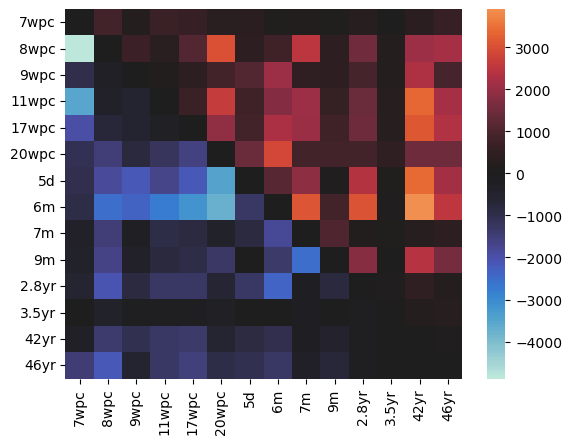

In [23]:
sns.heatmap(comps, cmap='icefire', center=0)

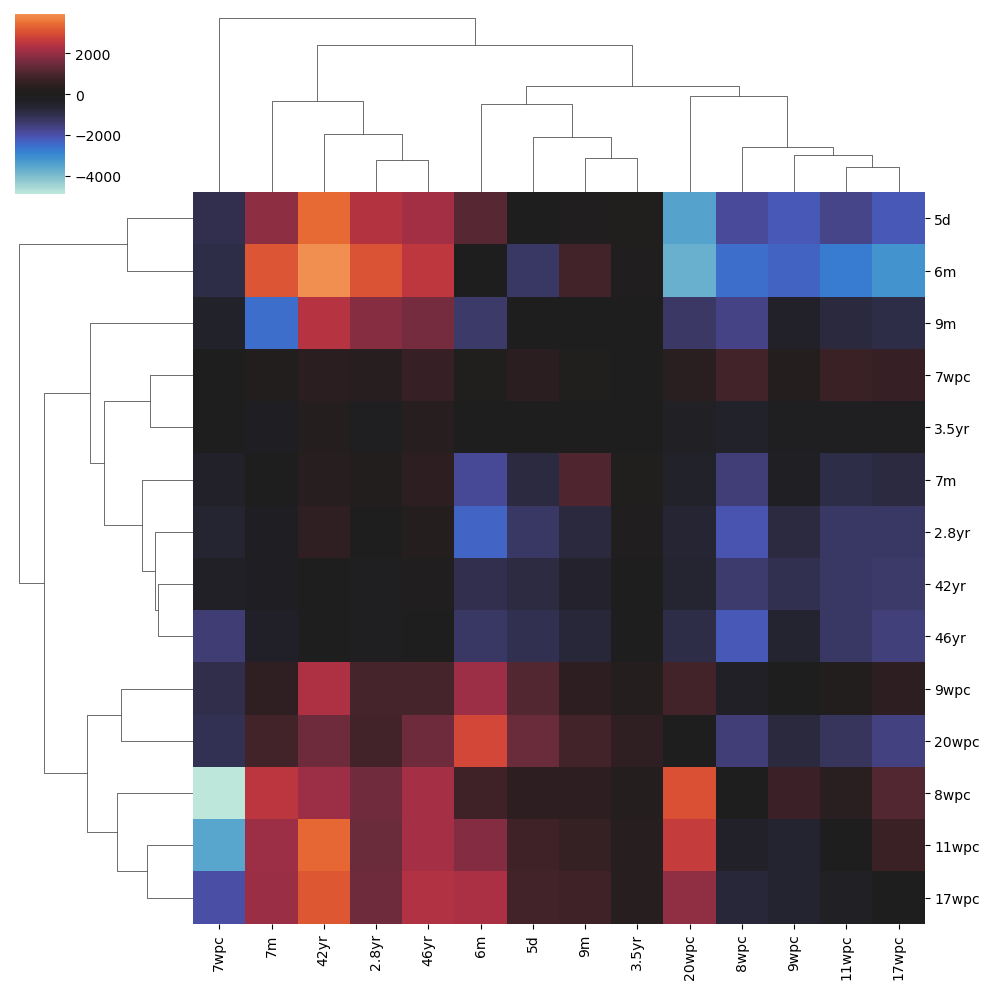

In [24]:
sns.clustermap(comps, cmap='icefire', center=0)